In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import os
import time

import torch
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor,Normalize, RandomHorizontalFlip, Resize
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader

import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

from PIL import Image

from torch.utils.data import ConcatDataset

### GPU Setting ###
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
print(DEVICE)

cuda


In [3]:
### Custom Dataset ###
# Create DataLoader
class CUB2011(Dataset):
  def __init__(self, transform, mode='train'):
    self.mode = mode
    self.transform = transform

    if self.mode == 'train':
      self.image_folder = os.listdir('/content/gdrive/MyDrive/Colab Notebooks/CUB_200_2011_repackage_class50/datasets/train')
    elif self.mode == 'valid':
      self.image_folder = os.listdir('/content/gdrive/MyDrive/Colab Notebooks/CUB_200_2011_repackage_class50/datasets/valid')
    elif self.mode == 'test':
      self.image_folder = os.listdir('/content/gdrive/MyDrive/Colab Notebooks/CUB_200_2011_repackage_class50/datasets/test')

  def __len__(self):
    return len(self.image_folder)

  def __getitem__(self, idx):
    img_path = self.image_folder[idx]
    img = Image.open(os.path.join('/content/gdrive/MyDrive/Colab Notebooks/CUB_200_2011_repackage_class50/datasets', self.mode, img_path)).convert('RGB')
    img = self.transform(img)

    label = img_path.split('_')[-1].split('.')[0]
    label = int(label)
    return (img, label)

In [14]:
### Data Preprocessing & Data Augmentation ###
transforms_train_origin = transforms.Compose([transforms.Resize((448, 448)),transforms.ToTensor(),])
transforms_test = transforms.Compose([transforms.Resize((448,448)),transforms.ToTensor(),])
transforms_train_aug = transforms.RandomApply([
    transforms.Resize((448, 448)),
    transforms.RandomCrop(448),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),],p=1)

BATCH_SIZE = 32
train_set_origin = CUB2011(mode='train',
                    transform=transforms_train_origin)
val_set = CUB2011(mode='valid',
                  transform=transforms_test)
test_set = CUB2011(mode='test',
                  transform=transforms_test)

# 데이터 증강을 위해 원래 데이터를 복사하고 추가
train_set_augmented = CUB2011(mode='train', transform=transforms_train_aug)

# 두 데이터셋을 연결하여 새로운 훈련 데이터셋 생성
train_set_combined = ConcatDataset([train_set_origin, train_set_augmented])

print('Num of each dataset: ',len(train_set_combined),len(val_set),len(test_set))

# Dataloader class는 bath기반의 딥러닝모델 학습을 위해서 mini batch를 만들어주는 역할을 한다
# dataloader를 통해 dataset의 전체 데이터가 batch size로 나뉘게 된다
train_loader = DataLoader(train_set_combined,batch_size=BATCH_SIZE,shuffle=True)
val_loader = DataLoader(val_set,batch_size=BATCH_SIZE,shuffle=False)
test_loader = DataLoader(test_set,batch_size=BATCH_SIZE,shuffle=False)

print("Loaded dataloader")

Num of each dataset:  4720 296 298
Loaded dataloader


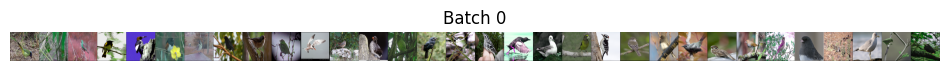

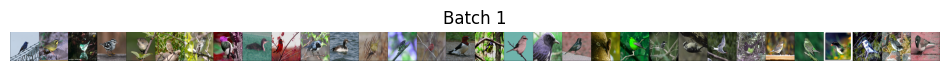

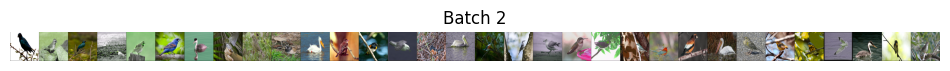

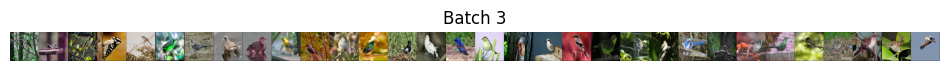

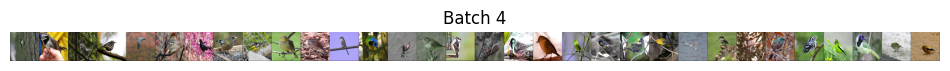

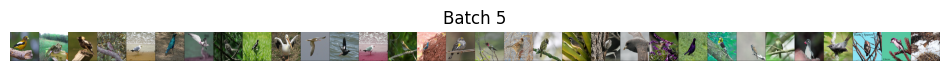

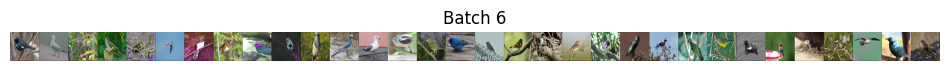

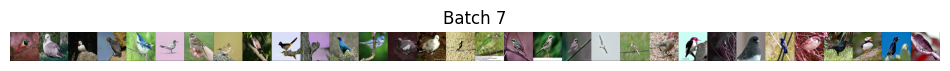

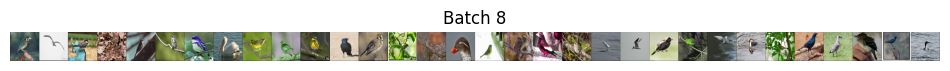

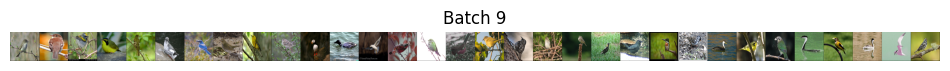

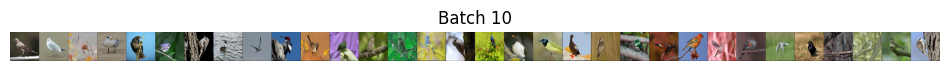

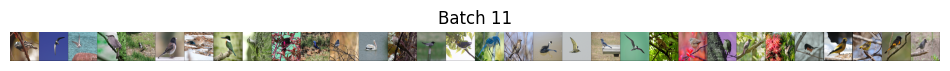

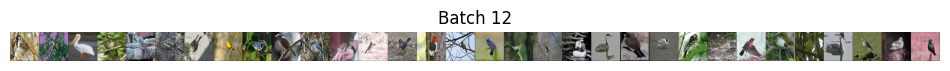

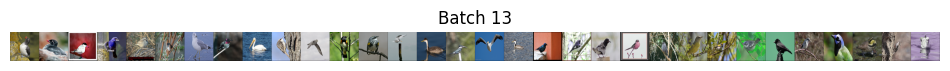

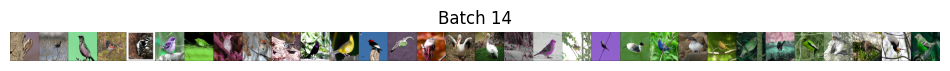

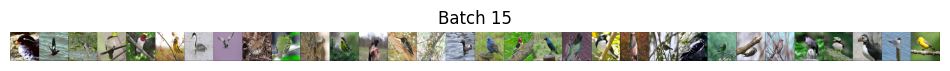

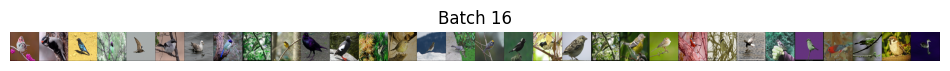

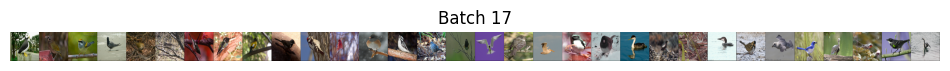

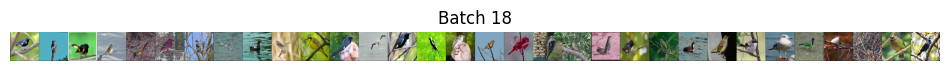

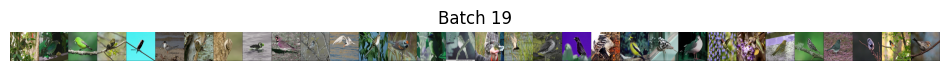

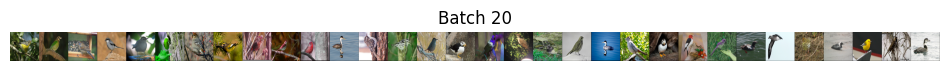

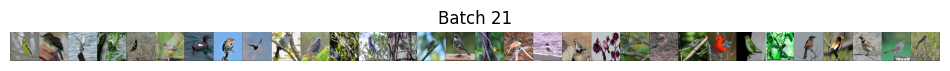

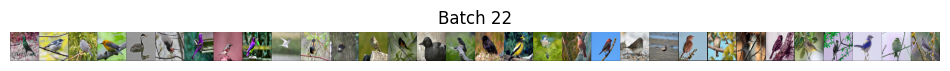

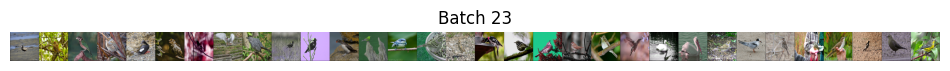

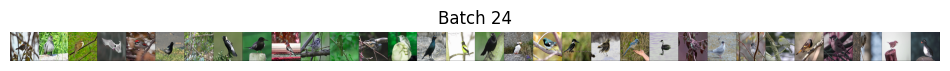

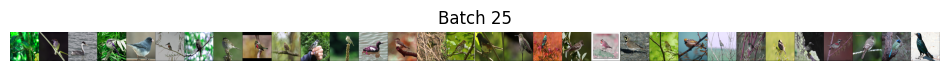

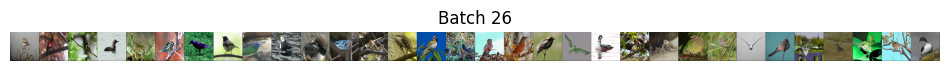

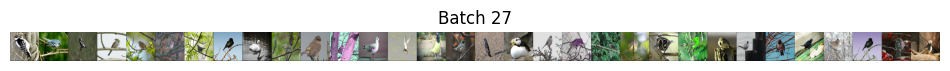

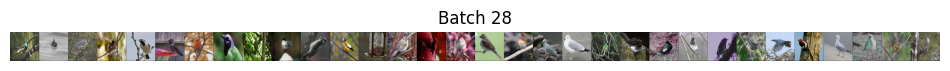

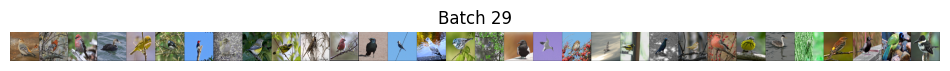

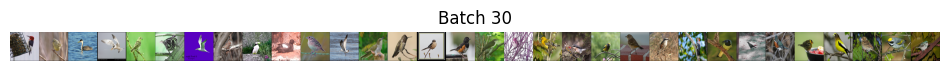

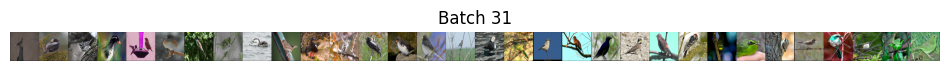

In [15]:
import matplotlib.pyplot as plt
import torchvision

# 데이터 로더에서 몇 개의 배치를 가져올지 지정합니다
num_batches_to_plot = BATCH_SIZE

# 데이터 로더에서 이미지 배치를 가져와 시각화합니다
for batch_idx, batch in enumerate(train_loader):
    if batch_idx >= num_batches_to_plot:
        break

    images, labels = batch
    batch_size = images.size(0)

    # 이미지 배치를 그리드 형태로 표시하기 위해 torchvision의 make_grid 함수를 사용합니다
    grid = torchvision.utils.make_grid(images, nrow=batch_size)

    # 이미지 그리기
    plt.figure(figsize=(12, 6))
    plt.imshow(grid.permute(1, 2, 0))  # 차원 순서를 바꿔서 이미지를 표시
    plt.title(f'Batch {batch_idx}')
    plt.axis('off')
    plt.show()

In [16]:
### Model / Optimizer ###
EPOCH = 30
lr = 0.1

model = models.resnet18(pretrained=True)

### Tranfer Learning ###
num_features = model.fc.in_features
model.fc = nn.Linear(num_features,50)
model.to(DEVICE)

optimizer = optim.SGD(model.parameters(),lr=lr)

print("Created a learning model and optimizer")

### Train/Evaluation ###
def train(model,train_loader,optimizer,epoch):
  # 모델을 학습 모드로 변환
  model.train()

  for i,(image,target) in enumerate(train_loader):
    # 각 image와 target을 앞서 설정한 DEVICE(GPU 혹은 CPU)에 보내기
    image,target = image.to(DEVICE),target.to(DEVICE)
    # data를 모델에 넣어서 hypothesis 획득
    output = model(image)
    # 반복 때마다 기울기를 새로 계산, 이 함수로 초기화
    optimizer.zero_grad()
    # 비교해서 loss 계산
    train_loss = F.cross_entropy(output,target).to(DEVICE)
    # loss를 backward 계산
    train_loss.backward()
    # 계산한 기울기를 앞서 정의한 알고리즘에 맞춰서 가중치를 수정
    optimizer.step()

    if i%10 ==0:
      print(
          f'Train Epoch: {epoch} [{i}/{len(train_loader)}]\tloss: {train_loss.item():6f}')

  return train_loss

def evaluate(model,val_loader):
  # 모델을 평가 모드로 변환
  model.eval()

  eval_loss = 0
  correct = 0
  with torch.no_grad():
    for i,(image,target) in enumerate(val_loader):
      image,target = image.to(DEVICE),target.to(DEVICE)
      output = model(image)

      eval_loss += F.cross_entropy(output,target, reduction='sum').item()
      pred = output.max(1,keepdim=True)[1]
      correct += pred.eq(target.view_as(pred)).sum().item()

  eval_loss /= len(val_loader.dataset)
  eval_accuracy = 100*correct / len(val_loader.dataset)
  return eval_loss,eval_accuracy

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 84.9MB/s]


Created a learning model and optimizer


In [17]:
### Main ###
start = time.time()
best = 0
for epoch in range(EPOCH):
  train_loss = train(model,train_loader,optimizer,epoch)
  val_loss,val_accuracy = evaluate(model,val_loader)

  # Save best model
  if val_accuracy > best:
    best = val_accuracy
    torch.save(model.state_dict(),"./best_model.pth")

  print(f"[{epoch}]Validation Loss: {val_loss:.4f},Accuracy: {val_accuracy:.4f}%")

# Test result
test_loss,test_accuracy = evaluate(model,test_loader)
print(f'[FINAL] Test Loss: {test_loss:.4f},Accuracy: {test_accuracy:.4f}%')

end = time.time()
elasped_time = end - start

print("Best Accuracy: ",best)
print(
    f"Elasped Time: {int(elasped_time/3600)}h, {int(elasped_time/60)}m, {int(elasped_time%60)}s")
print(
    f"time: {int(elasped_time/3600)}h, {int(elasped_time/60)}m, {int(elasped_time%60)}s")

Train Epoch: 0 [0/148]	loss: 4.207138
Train Epoch: 0 [10/148]	loss: 4.671128
Train Epoch: 0 [20/148]	loss: 3.041712
Train Epoch: 0 [30/148]	loss: 2.847075
Train Epoch: 0 [40/148]	loss: 2.676265
Train Epoch: 0 [50/148]	loss: 2.118591
Train Epoch: 0 [60/148]	loss: 1.342133
Train Epoch: 0 [70/148]	loss: 1.489650
Train Epoch: 0 [80/148]	loss: 1.094237
Train Epoch: 0 [90/148]	loss: 1.126480
Train Epoch: 0 [100/148]	loss: 0.774095
Train Epoch: 0 [110/148]	loss: 0.693524
Train Epoch: 0 [120/148]	loss: 1.235623
Train Epoch: 0 [130/148]	loss: 0.790083
Train Epoch: 0 [140/148]	loss: 0.340006
[0]Validation Loss: 1.2957,Accuracy: 62.8378%
Train Epoch: 1 [0/148]	loss: 0.624123
Train Epoch: 1 [10/148]	loss: 0.489730
Train Epoch: 1 [20/148]	loss: 0.253306
Train Epoch: 1 [30/148]	loss: 0.316286
Train Epoch: 1 [40/148]	loss: 0.287961
Train Epoch: 1 [50/148]	loss: 0.261973
Train Epoch: 1 [60/148]	loss: 0.502117
Train Epoch: 1 [70/148]	loss: 0.295817
Train Epoch: 1 [80/148]	loss: 0.176952
Train Epoch: 1 